# Skin Lesion Features Extraction

In order to evaluate if a skin lesion might be a melanoma, dermatologists evaluate ABCD features :
- __A : asymmetry__
- __B : border__
- __C : contour__
- __D : diameter__

Before convolutional networks, most methods tried to extract ABCD features in order to classify skin lesions.

In the following we implement and test some methods presented in by scientific community.

The next step would be to apply classification models, however there is not enough implemented features to obtain correct scores.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2

from sklearn import linear_model

from skimage.transform import resize
from skimage.transform import rotate, SimilarityTransform, warp
from skimage.filters import sobel
from skimage.morphology import dilation

In [2]:
masks = glob.glob('2016_ISIC_1_gt_train_resize/*.jpg')
masks.sort()
imgs = glob.glob('2016_ISIC_1_train_resize/*.jpg')
imgs.sort()

In [87]:
malignant_label = glob.glob('dataset/malignant/*')
malignant_label = [file.split('ISIC_')[::-1][0] for file in malignant_label]

benign_label = glob.glob('dataset/benign/*')
benign_label = [file.split('ISIC_')[::-1][0] for file in benign_label]

def which_label(path):
    
    ID = path.split('ISIC_')[::-1][0]
    
    if(ID in benign_label):
        return 0
    else:
        return 1

# Features computation

## Diameter

__First method :__ We downsize the image mask in order to iterate over contour pixels faster. We take the two points with the biggest distance to define the diameter.

__Second method :__ We fit an ellipse to the border points and compute it major axis length using the opencv function fitEllipse.

In [61]:
def read_mask(path):
    
    msk = plt.imread(path)
    msk = msk.mean(axis=2)/255. 
    msk = (msk > 0.5).astype('float32')
    
    return msk

def compute_border(mask):
    
    border = sobel(mask)
    
    return border

def compute_periphery(mask):
    
    periphery = dilation(compute_border(msk), np.ones((20,20)))
    
    return periphery

def compute_ellipse(mask):
    
    border = (np.where(compute_border(mask) > 0))
    X, Y = border[0], border[1]
    X,Y = X.reshape(-1,1), Y.reshape(-1,1)
    contours = np.concatenate((X,Y),axis=1)
    
    ellipse = cv2.fitEllipse(contours)
    
    return ellipse

def diameter_m1(image, mask):
    
    image = resize(compute_border(mask), (32, 32))
    
    border = compute_border(image)
    coords = np.where(border > 0)
    
    dmax = np.linalg.norm(coords[0] - coords[1])
    for i in range(len(coords[0])):
        for j in range(len(coords[0])):
            pt1, pt2 = np.array([coords[0][i], coords[1][i]]), np.array([coords[0][j], coords[1][j]])
            if np.linalg.norm(pt1 - pt2) > dmax :
                dmax = np.linalg.norm(pt1 - pt2)
                
    return np.array([dmax])

def diameter_m2(image, mask):

    ellipse = compute_ellipse(mask)
    diameter = max(ellipse[1])
    
    return np.array([diameter])

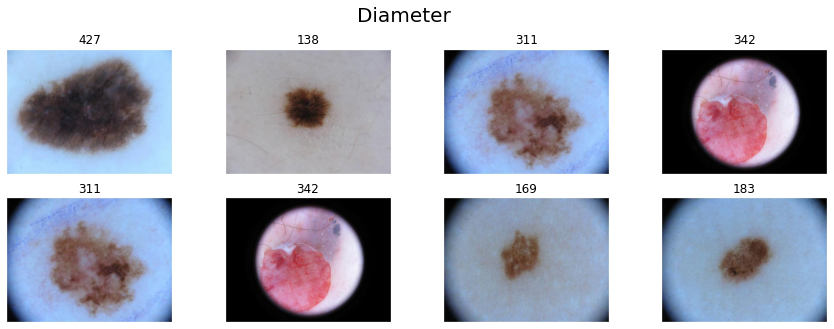

In [63]:
fig, axs = plt.subplots(2, 4, figsize=(15,5))

for i in range(4):
    for j in range(2):
        msk = read_mask(masks[i + 2*j])

        im = plt.imread(imgs[i + 2*j])
        axs[j][i].imshow(im)
        axs[j][i].axis('off')
        axs[j][i].set_title(int(diameter_m2(im, msk)[0]))
        
fig.suptitle("Diameter", fontsize=20, y=1.)
plt.show()

In [413]:
B_diam = []
M_diam = []

for i in range(len(masks)):
    msk = read_mask(masks[i])
    im = plt.imread(imgs[i])
    d = diameter_m2(im, msk)
    if which_label(imgs[i]) == 0:
        B_diam.append(d)
    else:
        M_diam.append(d)
        
B_diam = np.array(B_diam)
M_diam = np.array(M_diam)

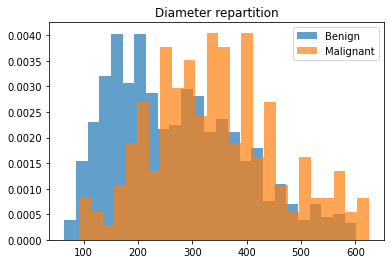

In [414]:
plt.hist(B_diam,bins=25, label='Benign', density=True, alpha=0.7)
plt.hist(M_diam,bins=25, label='Malignant', density=True, alpha=0.7)
plt.legend()
plt.title('Diameter repartition')
plt.show()

In [420]:
B_diam = np.array(B_diam)
M_diam = np.array(M_diam)

total = np.concatenate((B_diam, M_diam),axis=0)
total_features = total

## Contour

### Fractal dimension

Fractal dimension of a border might be relevant to measure irregularity. To compute it we use the counting boxes method approximation. 

__First method :__ Recursive counting box method.

__Second method :__ Boxes are counted using numpy the 2D histogramm function.

In [95]:
def scale_pixels_count(img, N, N_):
    
    result = [0 for i in range(N_)]
        
    if N == 1:
        result[0] = int((img[0][0] > 0))
        return result
    
    size = img.shape[0]//2
    
    patches = []
    patches.append(get_patch(img[:size,:size], N-1, N_))
    patches.append(get_patch(img[size:,:size], N-1, N_))
    patches.append(get_patch(img[size:,size:], N-1, N_))
    patches.append(get_patch(img[:size,size:], N-1, N_))
    
    for patch in patches:
        if patch[N-2] > 0:
            result[N-1] = 1
            
        for i in range(N-1):
            result[i] += patch[i]    
    
    return result

def fractal_dim_m1(image, mask):
    
    N_ = 10
    
    image = resize(compute_border(mask), (2**N_,2**N_))
    box_count = scale_pixels_count(image, N_, N_)
    box_count = np.array([np.log(x) for x in box_count])
    logs = np.array([np.log(2**k) for k in range(N_)])
    
    regr = linear_model.LinearRegression()
    regr.fit(logs.reshape(-1, 1), box_count.reshape(-1, 1))
        
    return np.abs(regr.coef_[0])


def fractal_dim_m2(image, mask):
    
    
    '''
    Source : https://francescoturci.net/2016/03/31/box-counting-in-numpy/
    '''
    
    pixels=[]
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j]>0:
                pixels.append((i,j))
                
    Lx=mask.shape[1]
    Ly=mask.shape[0]
    
    pixels=np.array(pixels)
    scales=np.logspace(0.01, 1, num=10, endpoint=False, base=2)
    Ns=[]
    
    for scale in scales:
        H, edges=np.histogramdd(pixels, bins=(np.arange(0,Lx,scale),np.arange(0,Ly,scale)))
        Ns.append(np.sum(H>0))
    
    coeffs=np.polyfit(np.log(scales), np.log(Ns), 1)
    
    return np.array([-coeffs[0]])

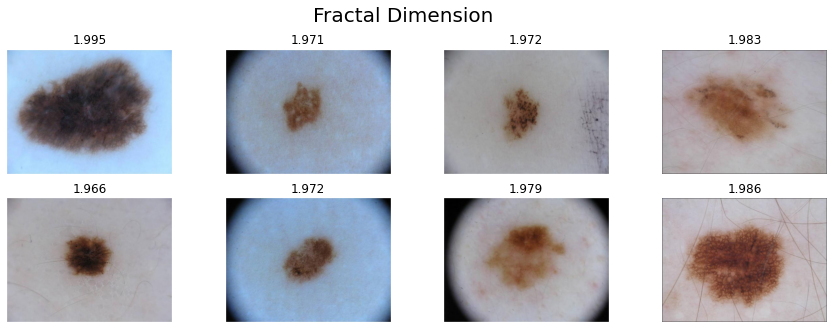

In [408]:
fig, axs = plt.subplots(2, 4, figsize=(15,5))

for i in range(4):
    for j in range(2):
        msk = read_mask(masks[4*i + j])

        im = plt.imread(imgs[4*i + j])
        axs[j][i].imshow(im)
        axs[j][i].axis('off')
        axs[j][i].set_title(round((fractal_dim_m2(im, msk)[0]),3))
        
fig.suptitle("Fractal Dimension", fontsize=20, y=1.)
plt.show()

In [187]:
B_frac_dim = []
M_frac_dim = []

for i in range(len(masks)):
    msk = read_mask(masks[i])
    im = plt.imread(imgs[i])
    d = fractal_dim_m2(im, msk)
    if which_label(imgs[i]) == 0:
        B_frac_dim.append(d)
    else:
        M_frac_dim.append(d)
        
B_frac_dim = np.array(B_frac_dim)
M_frac_dim = np.array(M_frac_dim)

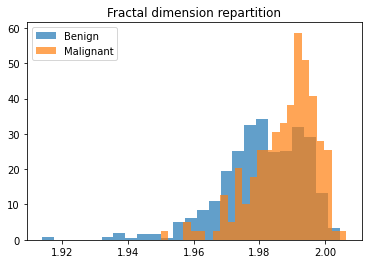

In [190]:
plt.hist(B_frac_dim, bins=25, label='Benign', density=True, alpha=0.7)
plt.hist(M_frac_dim, bins=25, label='Malignant', density=True, alpha=0.7)
plt.legend()
plt.title('Fractal dimension repartition')
plt.show()

In [422]:
total = np.concatenate((B_frac_dim, M_frac_dim),axis=0)
total_features = np.concatenate((total_features, total),axis=1)

## Asymmetry

__First method - Axis geometric asymmetry :__ We compute the asymmetry using the two major axis as symmetry axis. We compute the difference between each side.

__Second method - Texture asymmetry :__ We compute the standard deviation between pixels centroids based on quantiles over the image distribution. We normalize the deviation by the shape size.

### Axis asymmetry

In [191]:
def align_shape(mask, show=False):
    
    ellipse = compute_ellipse(mask)
    center = ellipse[0]
    center = (center[0] - msk.shape[0]//2, center[1] - msk.shape[1]//2)
    angle = ellipse[2]
        
    transf = SimilarityTransform(scale=1., rotation=0, translation=(center[1], center[0]))
    mask = rotate(warp(mask, transf), -angle)
    
    if show:
        plt.imshow(mask)
        plt.show()
    
    return mask
    
def compute_asymmetry(mask, show=False):
    
    size = mask.shape[0]//2
    
    diff = np.abs(mask[:size,:] - mask[size:,:][::-1])
    
    if show:
        plt.imshow(diff)
        plt.show()
    
    return diff.sum() / mask.sum()

def asymmetry(image, mask, show=False):
    
    mask_a = align_shape(mask, show)
    
    features = np.array([compute_asymmetry(mask_a, show), compute_asymmetry(rotate(mask_a,90), show)])
    
    return features

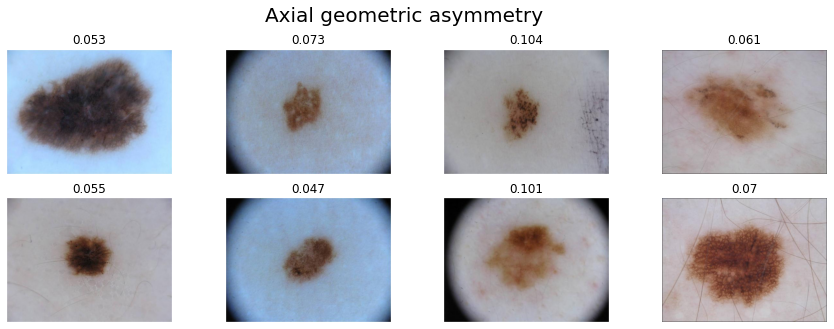

In [410]:
fig, axs = plt.subplots(2, 4, figsize=(15,5))

for i in range(4):
    for j in range(2):
        msk = read_mask(masks[j + 4*i])

        im = plt.imread(imgs[j + 4*i])
        axs[j][i].imshow(im)
        axs[j][i].axis('off')
        axs[j][i].set_title(round((asymmetry(im, msk)[0]),3))
        
fig.suptitle("Axial geometric asymmetry", fontsize=20, y=1.)
plt.show()

In [439]:
B_a = []
M_a = []

for i in range(len(masks)):
    msk = read_mask(masks[i])
    im = plt.imread(imgs[i])
    d = asymmetry(im, msk)
    if which_label(imgs[i]) == 0:
        B_a.append(d)
    else:
        M_a.append(d)
        
B_a = np.array(B_a)
M_a = np.array(M_a)

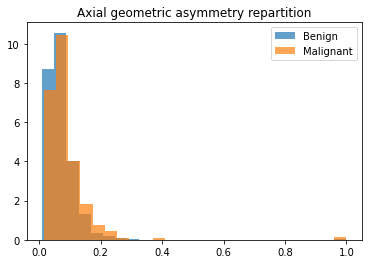

In [440]:
plt.hist(B_a.flatten(),bins=25, label='Benign', density=True, alpha=0.7)
plt.hist(M_a.flatten(),bins=25, label='Malignant', density=True, alpha=0.7)
plt.legend()
plt.title('Axial geometric asymmetry repartition')
plt.show()

In [441]:
total = np.concatenate((B_a, M_a),axis=0)
total_features = np.concatenate((total_features, total),axis=1)

### Texture asymmetry

In [443]:
def get_quantiles(image, mask):
    
    im = image.mean(axis=2)
    values = (im*mask)*(mask == 1.)
    values = values[values > 0.]
    
    quant = np.array([i/10 for i in range(10)])
    
    return np.quantile(values, quant)

def get_centroids(image, mask):

    Q = get_quantiles(image, mask)
    
    centers = []
    
    for q in Q:
        res = (mask == 1.)*(image.mean(axis=2) < q)
        points = np.where(res > 0)
        if (len(points[0]) > 0):
            X, Y = points[0], points[1]
            center = np.array([np.mean(X), np.mean(Y)])
            centers.append(center)
            
    return np.array(centers)

def asymmetry_color(image, mask, get_centr=False):
    
    image = image/255.
    mask = read_mask(masks[i])
    
    centers = get_centroids(image, mask)
    norm_dist = np.linalg.norm(centers - centers.mean(axis=0), axis=1).mean()
    norm_dist = norm_dist/(diameter_m2(image, mask)[0])
    
    if get_centr:
        return np.array([norm_dist]), centers
    else:
        return np.array([norm_dist])

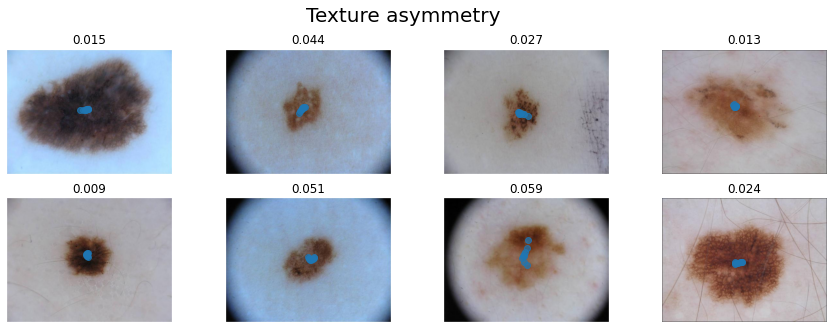

In [409]:
fig, axs = plt.subplots(2, 4, figsize=(15,5))

for i in range(4):
    for j in range(2):
        msk = read_mask(masks[j + 4*i])
        im = plt.imread(imgs[j + 4*i])
        norm_d, cent = asymmetry_color(im, msk, get_centr=True)
        
        axs[j][i].imshow(im)
        axs[j][i].axis('off')
        axs[j][i].set_title(round(norm_d[0],3))
        axs[j][i].scatter(cent[:,1], cent[:,0], alpha=0.7)
        
fig.suptitle("Texture asymmetry", fontsize=20, y=1.)
plt.show()

In [445]:
B_a_c = []
M_a_c = []

for i in range(len(masks)):
    msk = read_mask(masks[i])
    im = plt.imread(imgs[i])
    d = asymmetry_color(im, msk)
    if which_label(imgs[i]) == 0:
        B_a_c.append(d[0])
    else:
        M_a_c.append(d[0])
        
        
M_a_c = np.array(M_a_c)
B_a_c = np.array(B_a_c)

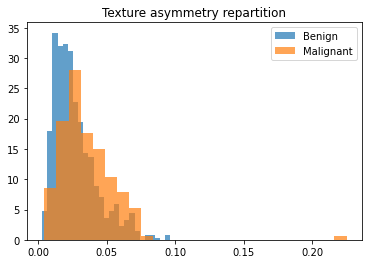

In [446]:
plt.hist(np.array(B_a_c),bins=25, label='Benign', density=True, alpha=0.7)
plt.hist(np.array(M_a_c),bins=25, label='Malignant', density=True, alpha=0.7)
plt.legend()
plt.title('Texture asymmetry repartition')
plt.show()

In [453]:
total = np.concatenate((B_a_c, M_a_c),axis=0)[...,np.newaxis]
total_features = np.concatenate((total_features, total),axis=1)

## Color

__First method :__ We compute statistics on pixels distribution using different color spaces. We compare statisticaly three different zones (inside the skin lesion, outside the skin lesion, at the border of the skin lesion).

__Second method :__ We compute an histogramm of the pixel distribution on the HSV color space.

In [156]:
from skimage.color import rgb2hsv, rgb2ycbcr, rgb2lab

def id_(x):
    return x

def color_distrib_features(image, mask):

    distrib = []
    colors = [id_, rgb2hsv, rgb2ycbcr, rgb2lab]
    
    for color in colors:
        for i in range(3):
            channel_inner = color(image)[:,:,i][mask == 0.]/255.
            channel_outer = color(image)[:,:,i][mask == 1.]/255.
            channel_peri = color(image)[:,:,i][compute_periphery(mask) == 1.]/255.
            
            channels = [channel_inner, channel_outer, channel_peri]
            means = [np.mean(c) for c in channels]
            stds = [np.std(c) for c in channels]
            ratio_means = [means[i % 2]/means[(i+1)%2] for i in range(2)]
            ratio_stds = [stds[i % 2]/stds[(i+1)%2] for i in range(2)]
            
            alls = means + stds + ratio_means + ratio_stds
            
            distrib += alls
            
            
    distrib = np.array(distrib)
    distrib[np.isnan(distrib)] = -1
            
    return distrib

def hsv_histogram(image, mask):
    '''
    Source : 
    A Comparative Study for Classification of Skin Cancer
    (Tri Cong Pham, Giang Son Tran, Thi Phuong Nghiem)
    '''
    
    c1 = rgb2hsv(image)[:,:,0][mask == 0.][..., np.newaxis]
    c2 = rgb2hsv(image)[:,:,1][mask == 0.][..., np.newaxis]
    c3 = rgb2hsv(image)[:,:,2][mask == 0.][..., np.newaxis]
        
    pixs = np.concatenate((c1, c2, c3), axis=1)
    
    feature = np.histogramdd(pixs, bins=(8,8,8))
        
    return feature

In [457]:
B_col = []
M_col = []

for i in range(len(masks)):
    msk = read_mask(masks[i])
    im = plt.imread(imgs[i])
    f = color_distrib_features(im, msk)
    if which_label(imgs[i]) == 0:
        B_col.append(f)
    else:
        M_col.append(f)

C:\Users\User\Desktop\melanoma_segmentation\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\Desktop\melanoma_segmentation\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\User\Desktop\melanoma_segmentation\venv\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User\Desktop\melanoma_segmentation\venv\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\User\Desktop\melanoma_segmentation\venv\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [458]:
M_col = np.array(M_col)
B_col = np.array(B_col)

In [463]:
total = np.concatenate((B_col, M_col),axis=0)
total_features = np.concatenate((total_features, total),axis=1)

In [464]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(total)

PCA(n_components=2)

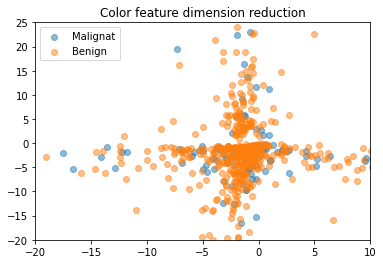

In [467]:
M_col_= pca.transform(M_col)
B_col_ = pca.transform(B_col)

plt.scatter(M_col_[:,0], M_col_[:,1], label='Malignat', alpha=0.5)
plt.scatter(B_col_[:,0], B_col_[:,1], label='Benign', alpha=0.5)
plt.xlim(-20, 10)
plt.ylim(-20, 25)
plt.legend()
plt.title("Color feature dimension reduction")
plt.show()

## Others

### Shape features

In [469]:
from skimage.measure import regionprops

def geometrical_features(image, mask):
    
    props = regionprops(mask.astype('uint8'))[0]
    
    eccentricity = props.eccentricity
    solidity = props.solidity
    
    f = np.array([eccentricity, solidity])
    
    return f

In [470]:
Bs = []
Ms = []
Be = []
Me = []

for i in range(len(masks)):
    msk = read_mask(masks[i])
    im = plt.imread(imgs[i])
    d = geometrical_features(im, msk)
    if which_label(imgs[i]) == 0:
        Bs.append(d[1])
        Be.append(d[0])
    else:
        Ms.append(d[1])
        Me.append(d[0])

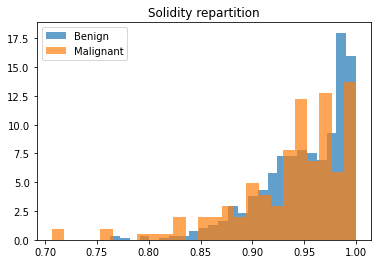

In [471]:
plt.hist(np.array(Bs),bins=25, label='Benign', density=True, alpha=0.7)
plt.hist(np.array(Ms),bins=25, label='Malignant', density=True, alpha=0.7)
plt.legend()
plt.title('Solidity repartition')
plt.show()

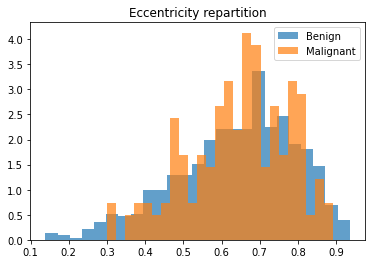

In [472]:
plt.hist(np.array(Be),bins=25, label='Benign', density=True, alpha=0.7)
plt.hist(np.array(Me),bins=25, label='Malignant', density=True, alpha=0.7)
plt.legend()
plt.title('Eccentricity repartition')
plt.show()

In [474]:
total = np.concatenate((Be, Me),axis=0)[..., np.newaxis]
total_features = np.concatenate((total_features, total),axis=1)

In [475]:
total = np.concatenate((Bs, Ms),axis=0)[..., np.newaxis]
total_features = np.concatenate((total_features, total),axis=1)

## Others Methods

### Texture based features

### Keypoints (ex : SIFT) based features

## Possible improvements

- __Other features computation (ex : co-occurence matrix).__
- __Investigating already computed features (ex : axial asymmetry / color).__
- __Applying machine learning models.__